In [1]:
import glob, os, shutil
import numpy as np
from sklearn import preprocessing
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem

from gnn_dataset import dataset, minmax_to_json, minmax_from_json

In [2]:
#if True:
#    files = glob.glob('md_data_train_val_test/md_data_*/processed/*')
#    for f in files:
#        os.remove(f)

In [3]:
root = "md_data_f02/"

sets = ["train","val","test"]

for s in sets:
    a = os.path.join(root,s)
    os.makedirs(a, exist_ok=True)
    b = os.path.join(a,"raw")
    c = os.path.join(a,"processed")
    os.makedirs(b, exist_ok=True)
    os.makedirs(c, exist_ok=True)

files = glob.glob('md_data/*')
for f in files:
    fname = f.split("/")[-1]
    sets = ["train","val","test"]
    for s in sets:
        a = os.path.join(root,s,"raw",fname)
        shutil.copyfile(f,a)


In [4]:
"""
atom node features:

sigma, epsilon, charge, atom_mass, ring_size, bond_no, Hs, PeriodTabNo, charge_mask

"""
mins = np.array([ 2.8, 0.0, -1.0, 1, 0, 0, 0, 1, -1 ])
maxs = np.array([ 5.8, 200, 1.0, 120, 6, 6, 6, 18, 1 ])
scale_dummy = np.array([mins,maxs])


scaler = preprocessing.MinMaxScaler().fit(scale_dummy)
#scaler = preprocessing.StandardScaler().fit(scale_dummy)

for s in sets:
    a = os.path.join(root,s,"processed","graph_scaler.gz")
    joblib.dump(scaler, a)


In [5]:

data_csv = "ini_data/13321_2024_820_MOESM2_ESM_raw.csv"
data = pd.read_csv(data_csv)

data = data.rename(columns={"CANON_SMILES": "canonical_smiles", "Temperature (K)": "temperature",
                           "Name": "iupac_name",# "Temperature (K)": "temperature"
                           })
data["isomeric_smiles"] = data["canonical_smiles"]

data["pressure"] = 101325
data["phase"] = "Liquid"
data["MD_density"] = data["MD_density"]*1000
data["viscosity"] = data["Viscosity (cP)"]*0.001
data["log_viscosity"] = np.log(data["viscosity"])
data["MD_HV"] *= 4184.0

ff = lambda x: Descriptors.MolWt(AllChem.MolFromSmiles(x["canonical_smiles"]))/1000
data["molarweight"] = data.apply(ff, axis=1)

data["volume"] = 1 / (data["MD_density"]  / (data["molarweight"]) )
data["family"] = "battery solvents"
data["dE"] = data["MD_HV"] + data["volume"]*data["pressure"] - 8.314*data["temperature"]
data["dE_nRT"] = data["dE"] / data["temperature"] / 8.314 / 4 # default n=4 (chain molecule)
data["a"] = 1.090e-3*data["molarweight"]**0.5*data["temperature"]**(3/2) / (data["volume"]**(2/3)*data["dE"]  )
data["log_a"] = np.log(data["a"])
data["a00"] = 4.99+2.73
data["log_value"] = data["log_viscosity"] - data["log_a"] + data["a00"]
data["value"] = np.exp(data["log_value"])

data.keys()


Index(['Index', 'iupac_name', 'canonical_smiles', 'temperature',
       'Inverse temperature (1/K)', 'Viscosity (cP)', 'log(Viscosity)',
       'MD_density', 'MD_FV', 'MD_Rg', 'MD_SP_E', 'MD_SP_V', 'MD_SP', 'MD_HV',
       'MD_RMSD', 'Reference', 'isomeric_smiles', 'pressure', 'phase',
       'viscosity', 'log_viscosity', 'molarweight', 'volume', 'family', 'dE',
       'dE_nRT', 'a', 'log_a', 'a00', 'log_value', 'value'],
      dtype='object')

In [6]:
data.shape

(3582, 31)

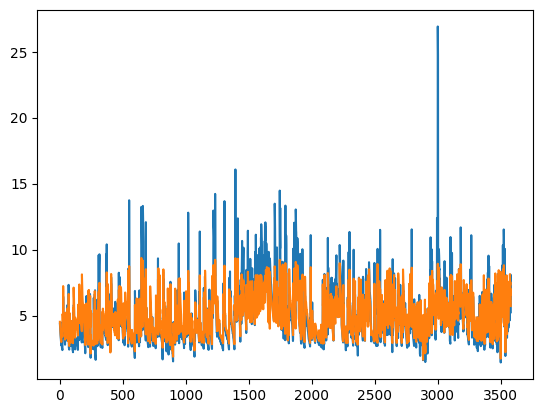

In [7]:
"""
data["a00"] is used to overlap log_value and dE_nRT !!!
"""
plt.plot(data["dE_nRT"])
plt.plot(data["log_value"])

In [8]:
n_total_data = len(data["canonical_smiles"])
n_train_data = int(n_total_data*0.7)
n_val_data = int(n_total_data*0.15)
n_test_data = n_total_data - n_train_data - n_val_data

mols = np.unique(data["canonical_smiles"])
np.random.shuffle(mols)

data_val = []
count = 0
for i,mol in enumerate(mols):
    dummy = data[data["canonical_smiles"]==mol]
    count += dummy.shape[0]
    data_val.append(dummy)
    if n_val_data <= count:
        break
data_val = pd.concat(data_val)

data_test = []
count = 0
for mol in mols[i+1:]:
    dummy = data[data["canonical_smiles"]==mol]
    count += dummy.shape[0]
    data_test.append(dummy)
    if n_test_data <= count:
        break
data_test = pd.concat(data_test)     

In [9]:
data_train = pd.concat([data,data_val]).drop_duplicates(keep=False)
data_train = pd.concat([data_train,data_test]).drop_duplicates(keep=False)

data_train.shape, data_val.shape, data_test.shape, n_total_data

((2506, 31), (538, 31), (538, 31), 3582)

In [10]:
data_train.shape[0] + data_val.shape[0] + data_test.shape[0] - n_total_data

0

In [11]:
a = os.path.join(root,"train","raw","raw_data.csv")
data_train.to_csv(a,index=False)

a = os.path.join(root,"val","raw","raw_data.csv")
data_val.to_csv(a,index=False)

a = os.path.join(root,"test","raw","raw_data.csv")
data_test.to_csv(a,index=False)

In [12]:
data_csv = "raw_data.csv"

x_features = ["dE_nRT",'MD_density', 'MD_FV', 'MD_Rg', 'MD_SP_E', 'MD_SP_V', 'MD_SP', 'MD_HV', 'MD_RMSD']
scale_x_features_with=["log_value",'MD_density', 'MD_FV', 'MD_Rg', 'MD_SP_E', 'MD_SP_V', 'MD_SP', 'MD_HV', 'MD_RMSD']

a = os.path.join(root,"train")
data_train = dataset( a, data_csv, log_transform=False,
         x_features=x_features,
         y_features=["log_value"],
         keep_features=["log_a","temperature","log_viscosity","a00","identifier","iupac_name","family","graph_id"],
         scale_x_features_with=scale_x_features_with,
         keepXY=False )

sets = ["val","test"]
for s in sets:
    a = data_train.scalerX_path.replace("train",s)
    shutil.copyfile(data_train.scalerX_path,a)    
    a = data_train.scalerY_path.replace("train",s)
    shutil.copyfile(data_train.scalerY_path,a)    


Processing...


Br/C=C\Br
BrBr
BrC(Br)Br
BrC(Br)C(Br)Br
BrCBr
BrCCBr
BrCCCBr
C#CCCCCCC
C#CCO
C#N
C/C=C/C=O
C/C=C/c1ccc(O)c(OC)c1
C/C=C\CC
C1=CC2C3C=CC(C3)C2C1
C1=CC=CC=CC=C1
C1=CCCCC1
C1=CCCCCC1
C1=Cc2ccccc2C1
C1CCC2CCCCC2C1
C1CCCC1
C1CCCCC1
C1CCCCCC1
C1CCCCCCC1
C1CCOC1
C1CCOCC1
C1CC[C@H]2CCCC[C@@H]2C1
C1CC[C@H]2CCCC[C@H]2C1
C1CO1
C1COCCN1
C1COCCO1
C1COCO1
C1CSC1
C=C(C)C#N
C=C(C)C(=C)C
C=C(C)C(=O)O
C=C(C)C(=O)OC1CCCCC1
C=C(C)C(=O)OCC(C)C
C=C(C)C(=O)OCC1CO1
C=C(C)C(=O)OCCCC
C=C(C)C(=O)OCCN(C)C
C=C(C)C=O
C=C(C)c1ccccc1
C=C1CCC2CC1C2(C)C
C=C=C
C=CC#N
C=CC(=C)C
C=CC(=O)OC
C=CC(=O)OCC(C)C
C=CC(=O)OCCCC
C=CC(C)(O)CCC=C(C)C
C=CC(C)=O
C=CC(N)=O
C=CC=C
C=CC=O
C=CCBr
C=CCC(=O)O
C=CCCC=C
C=CCCCCCC
C=CCCCCCCC
C=CCCCCCCCC
C=CCCCCCCCCC
C=CCCCCCCCCCC
C=CCCCCCCCCCCCC
C=CCCCCCCCCCCCCC
C=CCCCCCCCCCCCCCCC
C=CCCCCCCCCCCCCCCCCC
C=CCCCCCCCCCCCCCCCCCC
C=CCI
C=CCNc1ccccc1
C=CCO
C=CCOC(=O)/C=C\C(=O)OCC=C
C=CCOC(=O)Cl
C=CCOC(=O)c1ccccc1C(=O)OCC=C
C=CCOC(C)=O
C=CCSC#N
C=CCc1ccc(O)c(OC)c1
C=CCc1ccc2c(c1)OCO2
C=CCl
C=CN1CCCC1=O
C

Done!


In [13]:
data_train.scalerX_path

'md_data_f02/train/processed/data_scalerX.gz'

In [14]:
a = os.path.join(root,"val")
data_val = dataset( a, data_csv, log_transform=False,
         x_features=x_features,
         y_features=["log_value"],
         keep_features=["log_a","temperature","log_viscosity","a00","identifier","iupac_name","family","graph_id"],
         scale_x_features_with=scale_x_features_with,
         keepXY=False )

Processing...


Brc1ccccc1
C#Cc1ccccc1
C/C=C/c1ccc2c(c1)OCO2
C1=CCC=C1
C1=CCCCCCC1
C1CCC(C2CCCCC2)CC1
C=C(C#N)C(=O)OC
C=C(Cl)Cl
C=CCCCCCCCCCCCCCC
C=CCCl
C=CCN
C=CCOCC(C)O
C=Cc1ccc(C)cc1
CC(=O)CCC(C)C
CC(C)(Br)CBr
CC(C)CCO
CC(C)COC=O
CC(C)Cl
CC(C)OC(=O)Cl
CC(C)[N+](=O)[O-]
CC(CO)c1ccccc1
CC(F)(Cl)Cl
CC(F)F
CC1CCCC(C)C1
CC1CCCC1
CC=C(C)C
CC=C(C)[N+](=O)[O-]
CC=C(CC)[N+](=O)[O-]
CC=Cc1ccc(O)c(OC)c1
CCC(C)C(C)(C)C
CCC(C)Cl
CCC1CCCC1
CCCC(=O)O
CCCC(C)C(=O)O
CCCCBr
CCCCC#N
CCCCC(CC)COC(=O)C(F)(F)C(F)(F)F
CCCCCC1CCCCC1
CCCCCCC
CCCCCCC1CCCCC1
CCCCCCCC(C)CC(C)CC(C)C
CCCCCCCC1CCCCC1
CCCCCCCCC(C)O
CCCCCCCCCC(C)OC(=O)CCCCCCCC
CCCCCCCCCCCC
CCCCCCCCCCCC(=O)O
CCCCCCCCCCCC(C)CC(C)CC(C)C
CCCCCCCCCCCCC
CCCCCCCCCCCCCC(=O)OC(C)C
CCCCCCCCCCCCCC(=O)OCC
CCCCCCCCCCCCCCC1CCCC1
CCCCCCCCCCCCCCC1CCCCC1
CCCCCCCCCCCCCCCCC1CCCC1
CCCCCCCCCCCCCCCCC1CCCCC1
CCCCCCCCCCCCCCCCO
CCCCCCCCCCCCCCc1ccccc1
CCCCCCCCCCCCc1ccccc1
CCCCCCCOC=O
CCCCCCOC=O
CCCCCCOCC
CCCCCOC(=O)CC(CC(=O)OCCCCC)C(=O)OCCCCC
CCCCCc1ccccc1
CCCCI
CCCCN(CCCC)CCCC
CCCCO
CCCCO

Done!


In [15]:
a = os.path.join(root,"test")
data_test = dataset( a, data_csv, log_transform=False,
         x_features=x_features,
         y_features=["log_value"],
         keep_features=["log_a","temperature","log_viscosity","a00","identifier","iupac_name","family","graph_id"],
         scale_x_features_with=scale_x_features_with,
         keepXY=False )

Processing...


C1=CCCC1
C1CC2OC2CC1C1CO1
C=C(C)C(=O)OC
C=C(C)C1CC=C(C)C(=O)C1
C=CC(=O)O
C=CCCCCCCCCCCCCCCCC
CC(=O)C(C)C
CC(=O)N(C)c1ccccc1
CC(=O)OCC(C)C
CC(=O)Oc1ccccc1
CC(=O)c1ccc(O)cc1
CC(=O)c1ccccc1
CC(C)(C)O
CC(C)=O
CC(C)Br
CC(C)C#N
CC(C)CC(C)(C)C
CC(C)CC1CCCCC1
CC(C)Cc1ccccc1
CC(C)I
CC(C)N
CC(CO)C(F)(F)F
CC1C=CCC1
CC1CN1
CCC(C)(C)C
CCC(C)(C)CC
CCC(C)(C)O
CCC(C)CO
CCC(C)N
CCC(C)c1ccccc1
CCC(O)CO
CCCC
CCCC(=O)OCC(C)C
CCCC(C)CC
CCCC(C)CC(C)CC(C)C
CCCC(CCC)C(=O)O
CCCCC(=O)OCC
CCCCC(=O)OCCC
CCCCC1CCCC1
CCCCC1CCCCC1
CCCCCCCC(=O)O
CCCCCCCC(=O)OC
CCCCCCCC(C)=O
CCCCCCCCC1CCCC1
CCCCCCCCC=CCCCCCCCC(=O)O
CCCCCCCCCC(=O)O
CCCCCCCCCC1CCCC1
CCCCCCCCCC1CCCCC1
CCCCCCCCCCBr
CCCCCCCCCCC(=O)OC(C)CCCC
CCCCCCCCCCC1CCCC1
CCCCCCCCCCCC(=O)OC
CCCCCCCCCCCC(=O)OCC
CCCCCCCCCCCCCCCC(=O)OCC
CCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCO
CCCCCCCCCCOC(C)=O
CCCCCCCCCCc1ccccc1
CCCCCCCCCOC(C)=O
CCCCCCOC(=O)CC(CC(=O)OCCCCCC)C(=O)OCCCCCC
CCCCCO
CCCCCOC(=O)CCC
CCCCCOC(C)=O
CCCCCOC=O
CCCCCl
CCCCOC(=O)CC
CCCCOC(=O)CCC


Done!


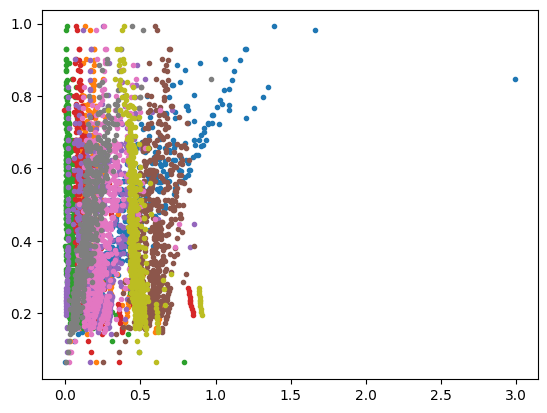

In [16]:
"""
this plot should 
"""
plt.plot( data_test.X_scaled,  data_test.Y_scaled, "." )

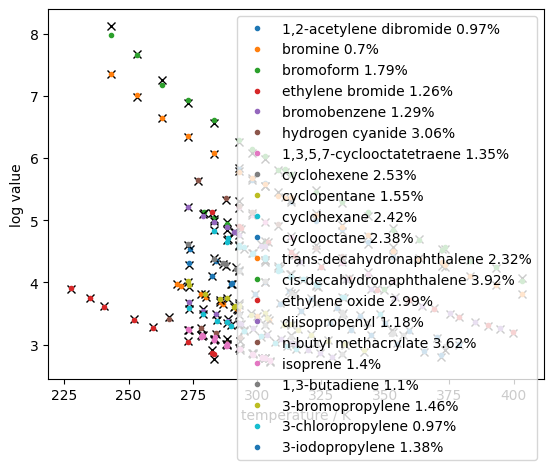

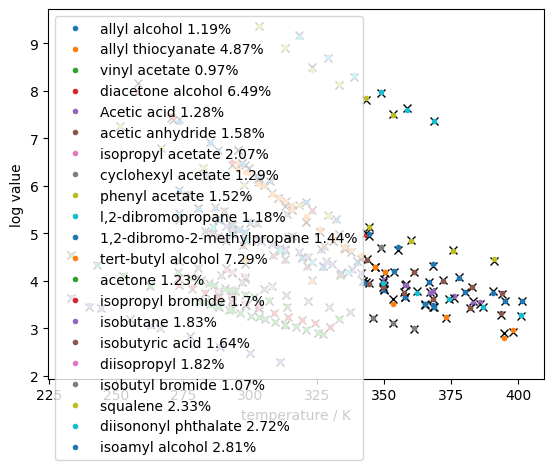

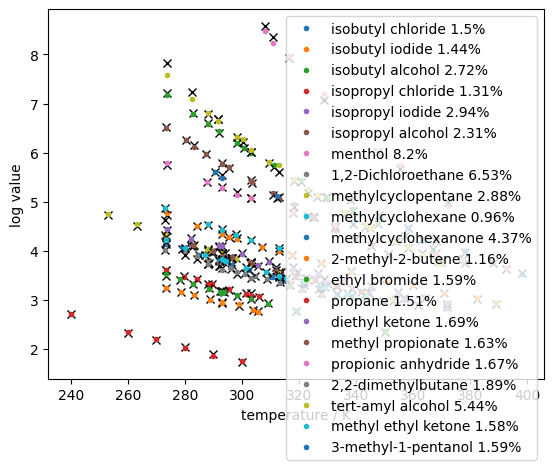

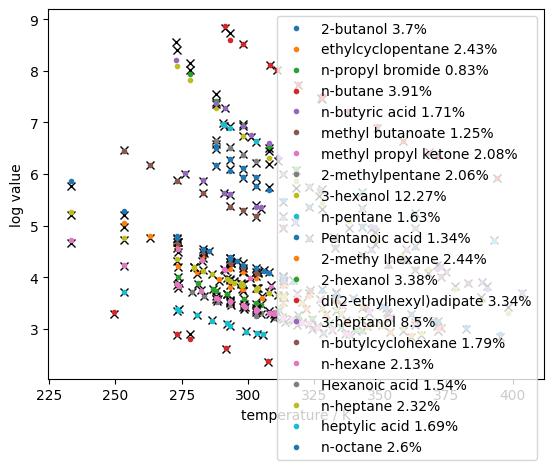

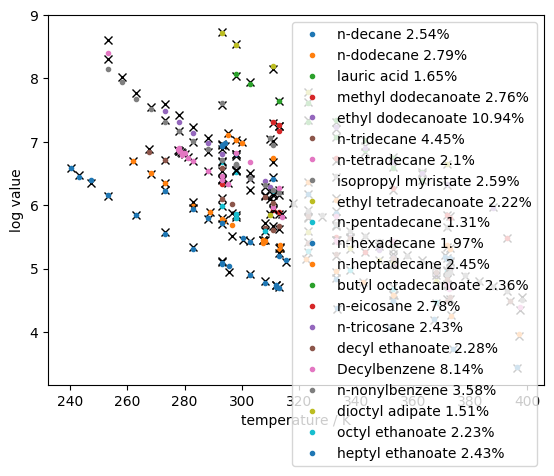

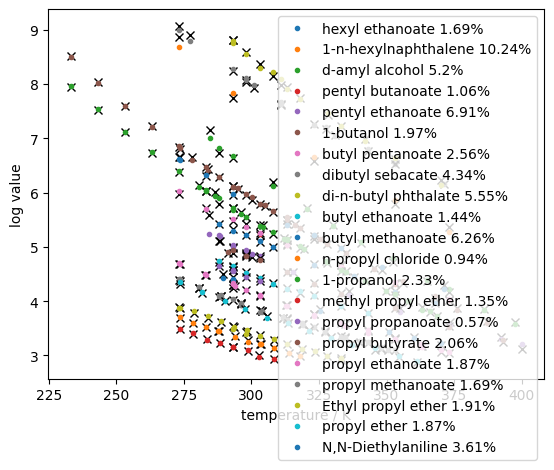

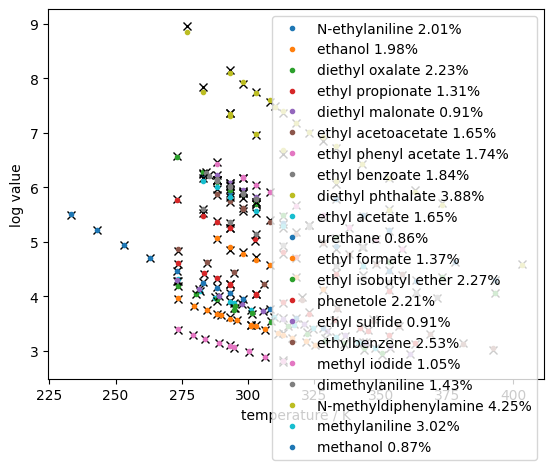

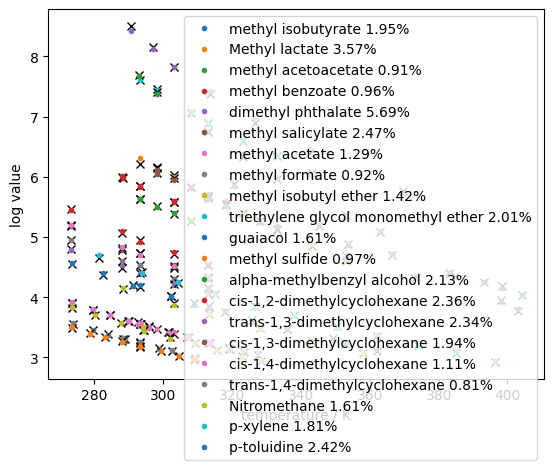

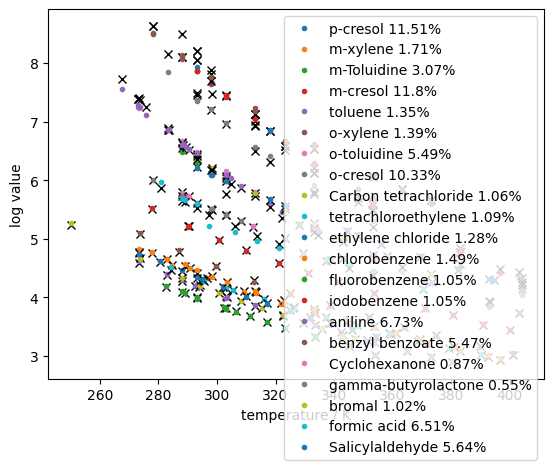

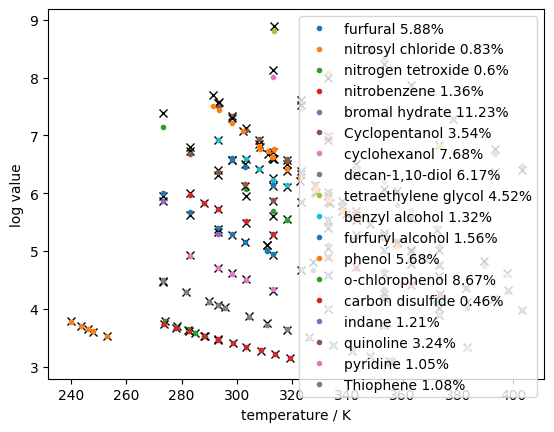

In [17]:
class Eyring():

    def __init__(self,data):
        self.data = data

        return

    def predict(self,p):
        a0,n = p
        n += 1
        y = self.data["dE_nRT"]*n - a0
        return y
    
    def error(self,p):           
        y = self.predict(p)
        yy = self.data["log_value"]
        error = np.sum( ( (y-yy) / yy) **2 )
        return error

usmiles = np.unique(data["canonical_smiles"])

errors = 0
count = 0
plot_count=0
fit_paras = []
for i,smiles in enumerate(usmiles):
    #print(smiles)

    md = data[data["canonical_smiles"]==smiles]
    if md.shape[0] > 4:

        f = Eyring(md)

        #res = minimize(f.error, [0,4], bounds=[[-10,+10],[1,12]])
        #res = minimize(f.error, [0,4], bounds=[[-10,+10],[.1,12]])
        res = minimize(f.error, [0,4], bounds=[[-10,+10],[-4,12]])
        #print(res.x)
        y = f.predict(res.x)
        fit_paras.append(res.x)
        
        vis = md["value"]
        log_vis = np.log(vis)
        T = md["temperature"]

        error = np.abs(( np.exp(y) - vis ) / vis)
        error = round(np.mean(error)*100,2)
        
        plt.plot(T,log_vis,"kx")
        plt.plot(T,y,".", label=md["iupac_name"].iloc[0]+" "+str(error)+"%")

        #break
        errors += error
        count += 1
        if count > 20:
            #break
            plt.xlabel("temperature / K")
            plt.ylabel("log value")
            plt.legend()
            #plt.savefig("n_a0_fit_"+str(int(plot_count))+".png")
            #plt.savefig("n_a0_fit_"+str(int(plot_count))+".pdf")
            plt.show()
            plt.close()        
            count = 0
            plot_count += 1

plt.xlabel("temperature / K")
plt.ylabel("log value")
plt.legend()

plt.show()
plt.close()

fit_paras = np.array(fit_paras).T


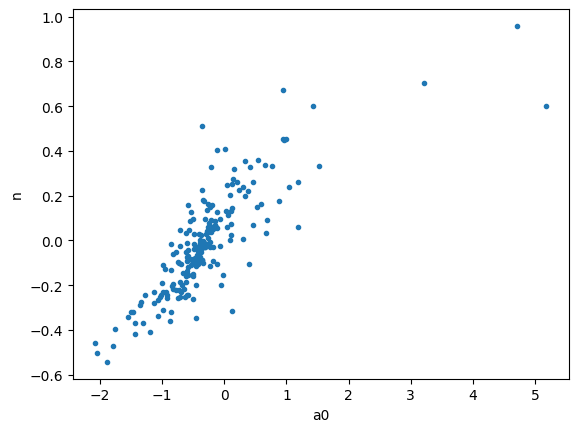

In [18]:
plt.plot( fit_paras[0], fit_paras[1], "." )
plt.xlabel("a0")
plt.ylabel("n")
plt.savefig("para_correlation.png")
plt.savefig("para_correlation.pdf")

In [19]:
np.min( data["log_viscosity"] ), np.max( data["log_viscosity"] )

(-9.210340371976182, -3.6298561136644754)

In [20]:
np.max( data["log_viscosity"] ) - np.min( data["log_viscosity"] )

5.5804842583117065

In [21]:
root

'md_data_f02/'